In [2]:
!pip install contextily

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import folium
from folium.plugins import HeatMap

import geopandas as gpd
import contextily as ctx
import plotly.express as px

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# read the CSV file with a comma delimeter
df = pd.read_csv('/content/drive/MyDrive/praktikum_ml/praktikum11/data/worldcities.csv')

df.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6870,139.7495,Japan,JP,JPN,Tōkyō,primary,37785000.0,1392685764
1,Jakarta,Jakarta,-6.1750,106.8275,Indonesia,ID,IDN,Jakarta,primary,33756000.0,1360771077
2,Delhi,Delhi,28.6100,77.2300,India,IN,IND,Delhi,admin,32226000.0,1356872604
3,Guangzhou,Guangzhou,23.1300,113.2600,China,CN,CHN,Guangdong,admin,26940000.0,1156237133
4,Mumbai,Mumbai,19.0761,72.8775,India,IN,IND,Mahārāshtra,admin,24973000.0,1356226629


In [6]:
df = df.dropna(subset=['lat','lng'])
df = df.drop_duplicates()

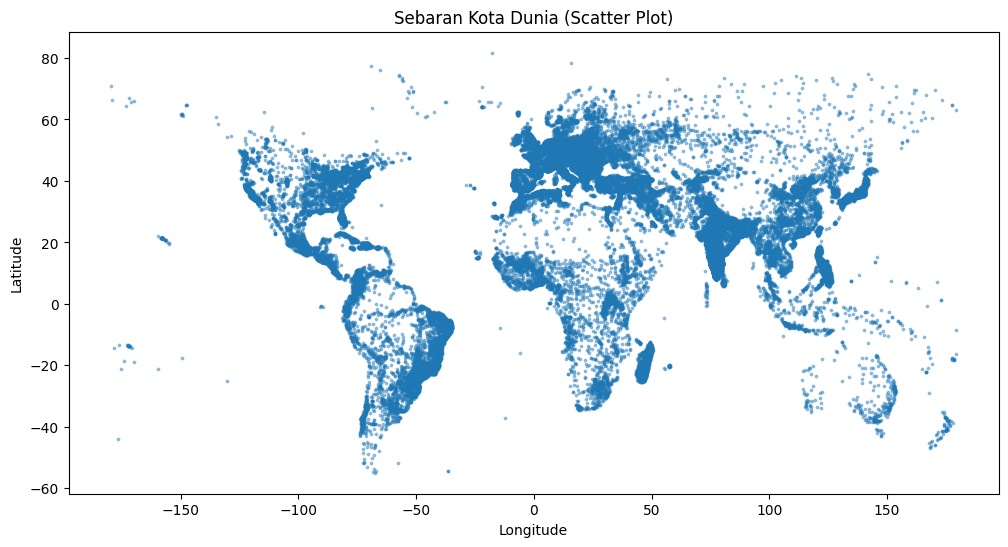

In [7]:
plt.figure(figsize=(12,6))
plt.scatter(df['lng'], df['lat'], s=3, alpha=0.4)
plt.title("Sebaran Kota Dunia (Scatter Plot)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [8]:
m = folium.Map(location=[20,0], zoom_start=2)
HeatMap(df[['lat','lng']].values.tolist(), radius=6).add_to(m)
m


In [9]:
top_5 = df.groupby('country')['city'].count().sort_values(ascending=False).head(5)
bottom_5 = df.groupby('country')['city'].count().sort_values(ascending=True).head(5)
top_5, bottom_5

(country
 India            7108
 United States    5344
 Brazil           2961
 Germany          1759
 China            1732
 Name: city, dtype: int64,
 country
 American Samoa         1
 Antigua and Barbuda    1
 Anguilla               1
 Barbados               1
 Bermuda                1
 Name: city, dtype: int64)

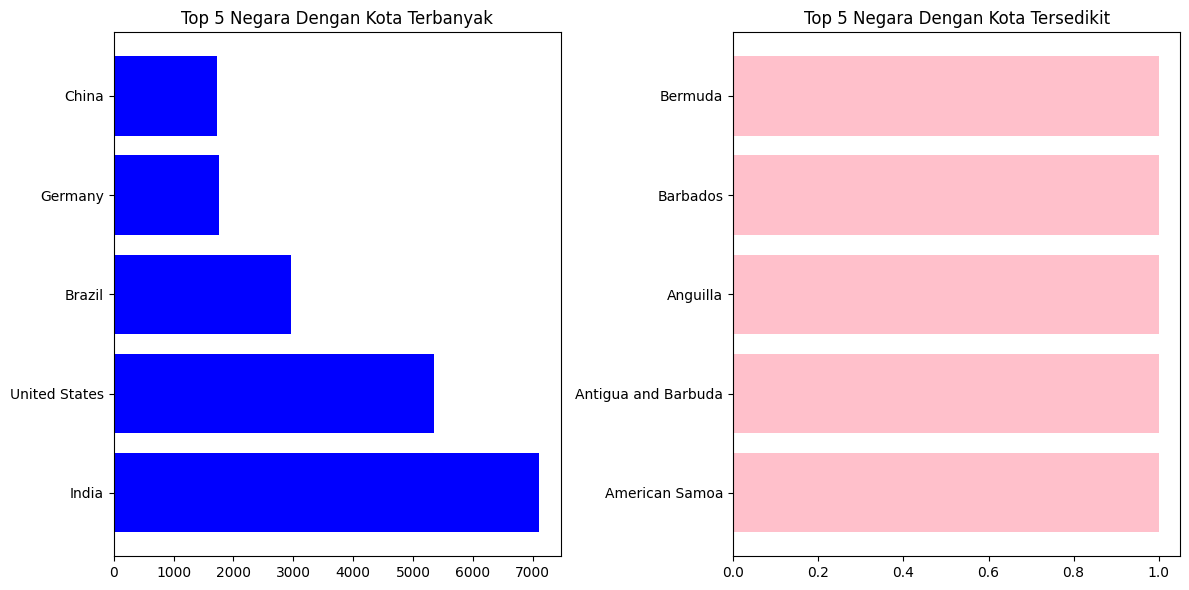

In [11]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1,2)

ax1 = plt.subplot(gs[0,0])
ax1.barh(top_5.index, top_5.values, color='blue')
ax1.set_title('Top 5 Negara Dengan Kota Terbanyak')

ax2 = plt.subplot(gs[0,1])
ax2.barh(bottom_5.index, bottom_5.values, color='pink')
ax2.set_title('Top 5 Negara Dengan Kota Tersedikit')

plt.tight_layout()
plt.show()


In [12]:
coord = df[['lat','lng']]
scaler = RobustScaler()
coord_scaled = scaler.fit_transform(coord)
coord_scaled[:5]

array([[ 0.1561913 ,  1.03325584],
       [-1.21966466,  0.76170586],
       [-0.07640467,  0.5175773 ],
       [-0.2565129 ,  0.81476294],
       [-0.38975026,  0.48167665]])

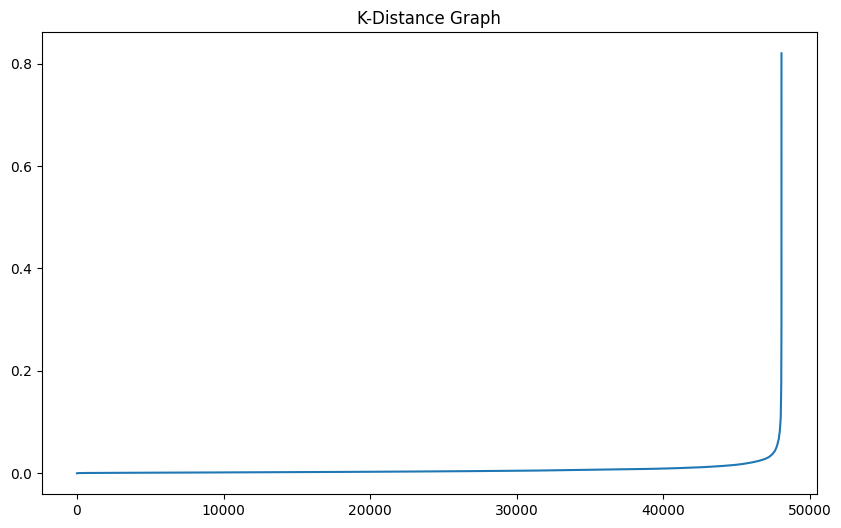

In [13]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(coord_scaled)
distances, indices = neighbors_fit.kneighbors(coord_scaled)
distances = np.sort(distances[:,4])

plt.figure(figsize=(10,6))
plt.plot(distances)
plt.title('K-Distance Graph')
plt.show()

In [14]:
eps_value = 0.07
min_samples_value = 5

db = DBSCAN(eps=eps_value, min_samples=min_samples_value)
labels = db.fit_predict(coord_scaled)

df['cluster'] = labels
df['cluster'].value_counts()

,count
cluster,
0,34196
1,13281
2,213
-1,118
4,57
5,36
3,30
11,16
14,15


In [15]:
if len(set(labels)) > 1 and not set(labels)=={-1}:
    print('Silhouette Score:', silhouette_score(coord_scaled, labels))
else:
    print('Silhouette tidak dapat dihitung.')

Silhouette Score: -0.23604174661784771


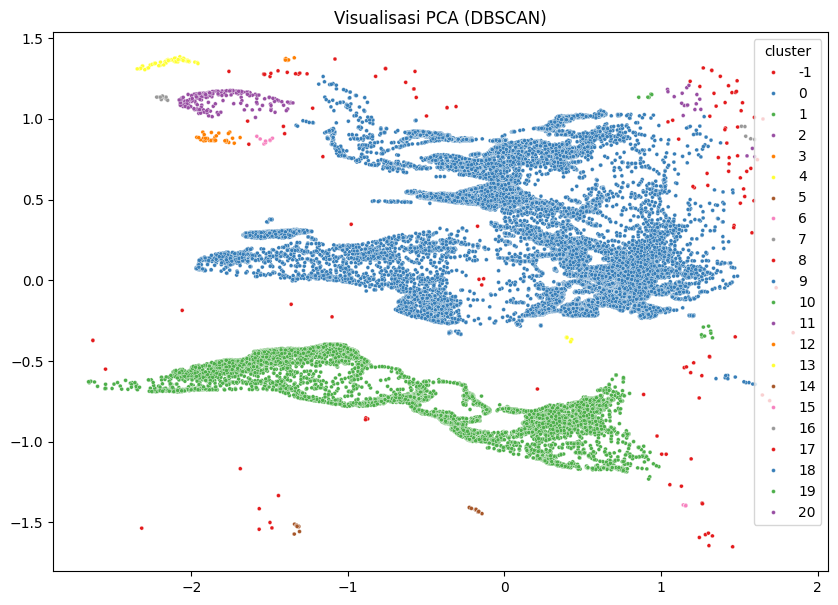

In [16]:
pca = PCA(n_components=2)
p2 = pca.fit_transform(coord_scaled)

plt.figure(figsize=(10,7))
sns.scatterplot(x=p2[:,0], y=p2[:,1], hue=df['cluster'], palette='Set1', s=8)
plt.title('Visualisasi PCA (DBSCAN)')
plt.show()

In [17]:
def interpret(c):
    if c == -1: return 'Noise'
    elif c == 0: return 'Cluster Utama'
    else: return 'Cluster Tambahan'

df['label_cluster'] = df['cluster'].apply(interpret)
df[['city','country','lat','lng','cluster','label_cluster']].head()

,city,country,lat,lng,cluster,label_cluster
0,Tokyo,Japan,35.6870,139.7495,0,Cluster Utama
1,Jakarta,Indonesia,-6.1750,106.8275,0,Cluster Utama
2,Delhi,India,28.6100,77.2300,0,Cluster Utama
3,Guangzhou,China,23.1300,113.2600,0,Cluster Utama
4,Mumbai,India,19.0761,72.8775,0,Cluster Utama


In [18]:
df.groupby('label_cluster')[['lat','lng']].mean()

fig = px.scatter_geo(df, lat='lat', lon='lng', color='label_cluster', hover_name='city')
fig.show()
